## Import all required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

## Import & Load Data

In [2]:
orders = pd.read_csv(r"C:\Users\hp\Downloads\My Project\Predicting Late Delivery in E-Commerce Orders & Optimizing Logistics\olist_orders_dataset.csv")
items = pd.read_csv(r"C:\Users\hp\Downloads\My Project\Predicting Late Delivery in E-Commerce Orders & Optimizing Logistics\olist_order_items_dataset.csv")
customers = pd.read_csv(r"C:\Users\hp\Downloads\My Project\Predicting Late Delivery in E-Commerce Orders & Optimizing Logistics\olist_customers_dataset.csv")
products = pd.read_csv(r"C:\Users\hp\Downloads\My Project\Predicting Late Delivery in E-Commerce Orders & Optimizing Logistics\olist_products_dataset.csv")
sellers = pd.read_csv(r"C:\Users\hp\Downloads\My Project\Predicting Late Delivery in E-Commerce Orders & Optimizing Logistics\olist_sellers_dataset.csv")
payments = pd.read_csv(r"C:\Users\hp\Downloads\My Project\Predicting Late Delivery in E-Commerce Orders & Optimizing Logistics\olist_order_payments_dataset.csv")
reviews = pd.read_csv(r"C:\Users\hp\Downloads\My Project\Predicting Late Delivery in E-Commerce Orders & Optimizing Logistics\olist_order_reviews_dataset.csv")

In [3]:
orders.head(1)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00


In [4]:
items.head(1)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29


In [5]:
customers.head(1)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP


In [6]:
products.head(1)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0


In [7]:
sellers.head(1)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP


In [8]:
payments.head(1)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33


In [9]:
reviews.head(1)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59


In [10]:
# Checking Orders table information
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [11]:
# Convert object dates to datetime
date_cols = ['order_purchase_timestamp', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
for col in date_cols:
    orders[col] = pd.to_datetime(orders[col],errors='coerce')


In [12]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  object        
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](4), object(4)
memory usage: 6.1+ MB


In [13]:
# Merge step by step
df = orders.merge(customers, on='customer_id', how='left') \
           .merge(items, on='order_id', how='left') \
           .merge(products, on='product_id', how='left') \
           .merge(sellers, on='seller_id', how='left') \
           .merge(payments, on='order_id', how='left') \
           .merge(reviews, on='order_id', how='left')


In [14]:
df.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,1.0,credit_card,1.0,18.12,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,3.0,voucher,1.0,2.00,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48


In [15]:
df.shape

(119143, 39)

In [16]:
df.isnull().sum() / df.shape[0]

order_id                         0.000000
customer_id                      0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_approved_at                0.001486
order_delivered_carrier_date     0.017508
order_delivered_customer_date    0.028713
order_estimated_delivery_date    0.000000
customer_unique_id               0.000000
customer_zip_code_prefix         0.000000
customer_city                    0.000000
customer_state                   0.000000
order_item_id                    0.006992
product_id                       0.006992
seller_id                        0.006992
shipping_limit_date              0.006992
price                            0.006992
freight_value                    0.006992
product_category_name            0.021336
product_name_lenght              0.021336
product_description_lenght       0.021336
product_photos_qty               0.021336
product_weight_g                 0.007159
product_length_cm                0

In [17]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,1.0,credit_card,1.0,18.12,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,3.0,voucher,1.0,2.00,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,2.0,voucher,1.0,18.59,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,1.0,boleto,1.0,141.46,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,1.0,credit_card,3.0,179.12,e73b67b67587f7644d5bd1a52deb1b01,5.0,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58


In [18]:
df.isnull().sum()

order_id                              0
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                   177
order_delivered_carrier_date       2086
order_delivered_customer_date      3421
order_estimated_delivery_date         0
customer_unique_id                    0
customer_zip_code_prefix              0
customer_city                         0
customer_state                        0
order_item_id                       833
product_id                          833
seller_id                           833
shipping_limit_date                 833
price                               833
freight_value                       833
product_category_name              2542
product_name_lenght                2542
product_description_lenght         2542
product_photos_qty                 2542
product_weight_g                    853
product_length_cm                   853
product_height_cm                   853


In [19]:
df = df[~df['order_delivered_customer_date'].isnull()]

In [20]:
df.dropna(subset=['review_comment_title', 'review_comment_message'],inplace=True)

In [21]:
product_cols = ['product_name_lenght', 'product_description_lenght', 'product_photos_qty',
                'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']
for col in product_cols:
    df[col].fillna(df[col].median(), inplace=True)

In [22]:
df['product_category_name'].fillna('unknown', inplace=True)

In [23]:
df.isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
product_category_name            0
product_name_lenght              0
product_description_lenght       0
product_photos_qty               0
product_weight_g                 0
product_length_cm                0
product_height_cm                0
product_width_cm                 0
seller_zip_code_prefix           0
seller_city                      0
seller_state        

In [24]:
df.shape

(11652, 39)

In [25]:
df.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,1.0,boleto,1.0,141.46,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50
19,dcb36b511fcac050b97cd5c05de84dc3,3b6828a50ffe546942b7a473d70ac0fc,delivered,2018-06-07 19:03:12,2018-06-12 23:31:02,2018-06-11 14:54:00,2018-06-21 15:34:32,2018-07-04,ccafc1c3f270410521c3c6f3b249870f,74820,...,1.0,credit_card,10.0,146.45,5a8608437f4b52bec5cd143f37258b5e,5.0,Nota dez,Obrigado pela atenção. Lojas lannister perfeit...,2018-07-03 00:00:00,2018-07-03 15:10:07


In [26]:
df.reset_index(inplace=True)

In [27]:
df = df.drop(columns=['index'],axis=1)

###  Delivery time-related features

In [28]:
df['delivery_days_actual'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days
df['delivery_days_estimated'] = (df['order_estimated_delivery_date'] - df['order_purchase_timestamp']).dt.days
df['delay_in_days'] = df['delivery_days_actual'] - df['delivery_days_estimated']

### Order day of week, and month

In [29]:
df['order_day_of_week'] = df['order_purchase_timestamp'].dt.dayofweek
df['order_day_name'] = df['order_purchase_timestamp'].dt.day_name()
df['order_month'] = df['order_purchase_timestamp'].dt.month


In [30]:
df['delivered_day_name'] = df['order_delivered_customer_date'].dt.day_name()


### Weekend delivery flag

In [31]:
df['delivered_on_weekend'] = df['order_delivered_customer_date'].dt.dayofweek.apply(lambda x: 1 if x in [5,6] else 0)

In [32]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,review_creation_date,review_answer_timestamp,delivery_days_actual,delivery_days_estimated,delay_in_days,order_day_of_week,order_day_name,order_month,delivered_day_name,delivered_on_weekend
0,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,2018-08-08 00:00:00,2018-08-08 18:37:50,13,19,-6,1,Tuesday,7,Tuesday,0
1,dcb36b511fcac050b97cd5c05de84dc3,3b6828a50ffe546942b7a473d70ac0fc,delivered,2018-06-07 19:03:12,2018-06-12 23:31:02,2018-06-11 14:54:00,2018-06-21 15:34:32,2018-07-04,ccafc1c3f270410521c3c6f3b249870f,74820,...,2018-07-03 00:00:00,2018-07-03 15:10:07,13,26,-13,3,Thursday,6,Thursday,0
2,f3e7c359154d965827355f39d6b1fdac,62b423aab58096ca514ba6aa06be2f98,delivered,2018-08-09 11:44:40,2018-08-10 03:24:51,2018-08-10 12:29:00,2018-08-13 18:24:27,2018-08-17,9c9242ad7f1b52d926ea76778e1c0c57,18052,...,2018-08-14 00:00:00,2018-08-14 21:52:46,4,7,-3,3,Thursday,8,Monday,0
3,acce194856392f074dbf9dada14d8d82,7e20bf5ca92da68200643bda76c504c6,delivered,2018-06-04 00:00:13,2018-06-05 00:35:10,2018-06-05 13:24:00,2018-06-16 15:20:55,2018-07-18,576ea0cab426cd8a00fad9a9c90a4494,41213,...,2018-06-17 00:00:00,2018-06-20 11:38:22,12,43,-31,0,Monday,6,Saturday,1
4,acce194856392f074dbf9dada14d8d82,7e20bf5ca92da68200643bda76c504c6,delivered,2018-06-04 00:00:13,2018-06-05 00:35:10,2018-06-05 13:24:00,2018-06-16 15:20:55,2018-07-18,576ea0cab426cd8a00fad9a9c90a4494,41213,...,2018-06-17 00:00:00,2018-06-20 11:38:22,12,43,-31,0,Monday,6,Saturday,1


### Count orders by month

In [33]:
order_counts_by_month = df['order_purchase_timestamp'].dt.month.value_counts().sort_index()

### Define high-demand months as those above average volume

In [34]:
average_orders = order_counts_by_month.mean()
high_demand_months = order_counts_by_month[order_counts_by_month > average_orders].index.tolist()

### Create the flag based on actual data

In [35]:
df['high_demand_period'] = df['order_purchase_timestamp'].dt.month.isin(high_demand_months).astype(int)

In [36]:
numeric_cols = [
    'delay_in_days', 'freight_value', 'price', 'payment_value',
    'product_weight_g', 'product_length_cm', 'product_width_cm',
    'product_height_cm', 'delivery_days_estimated', 'delivery_days_actual'
]

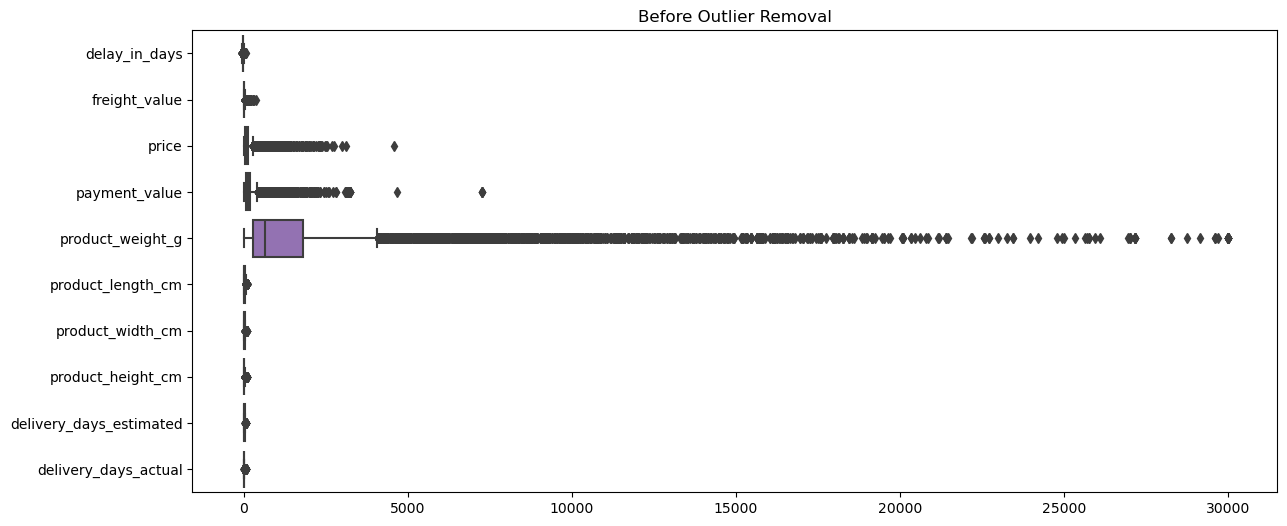

In [37]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df[numeric_cols], orient='h')
plt.title("Before Outlier Removal")
plt.show()

In [38]:
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col]=np.where(df[col] > upper, upper, df[col])
    df[col]=np.where(df[col]< lower, lower, df[col])


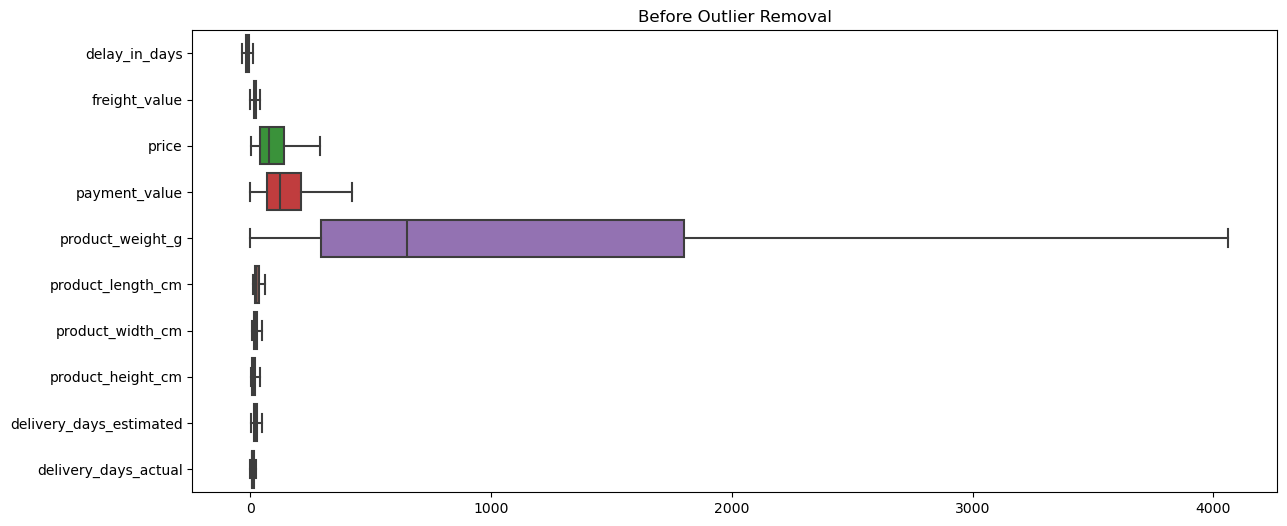

In [39]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df[numeric_cols], orient='h')
plt.title("Before Outlier Removal")
plt.show()

## Exploratory Data Analysis

### 1. Distribution of Delivery Delays

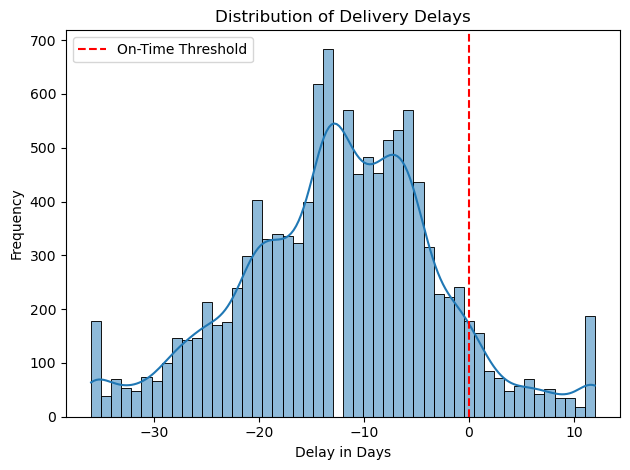

In [40]:
plt.figure()
sns.histplot(df['delay_in_days'], bins=50, kde=True)
plt.title("Distribution of Delivery Delays")
plt.xlabel("Delay in Days")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='--', label='On-Time Threshold')
plt.legend()
plt.tight_layout()
plt.show()

## 📌 Insight:
### 1. The majority of orders were delivered on time or earlier than expected.

### 2. A significant right skew indicates that some orders were delivered late, potentially causing dissatisfaction.

### 3. These late deliveries are outliers that the business should investigate further.

### 2. Average delay by seller state

In [41]:
seller_state_delay = df.groupby('seller_state')['delay_in_days'].mean().sort_values()

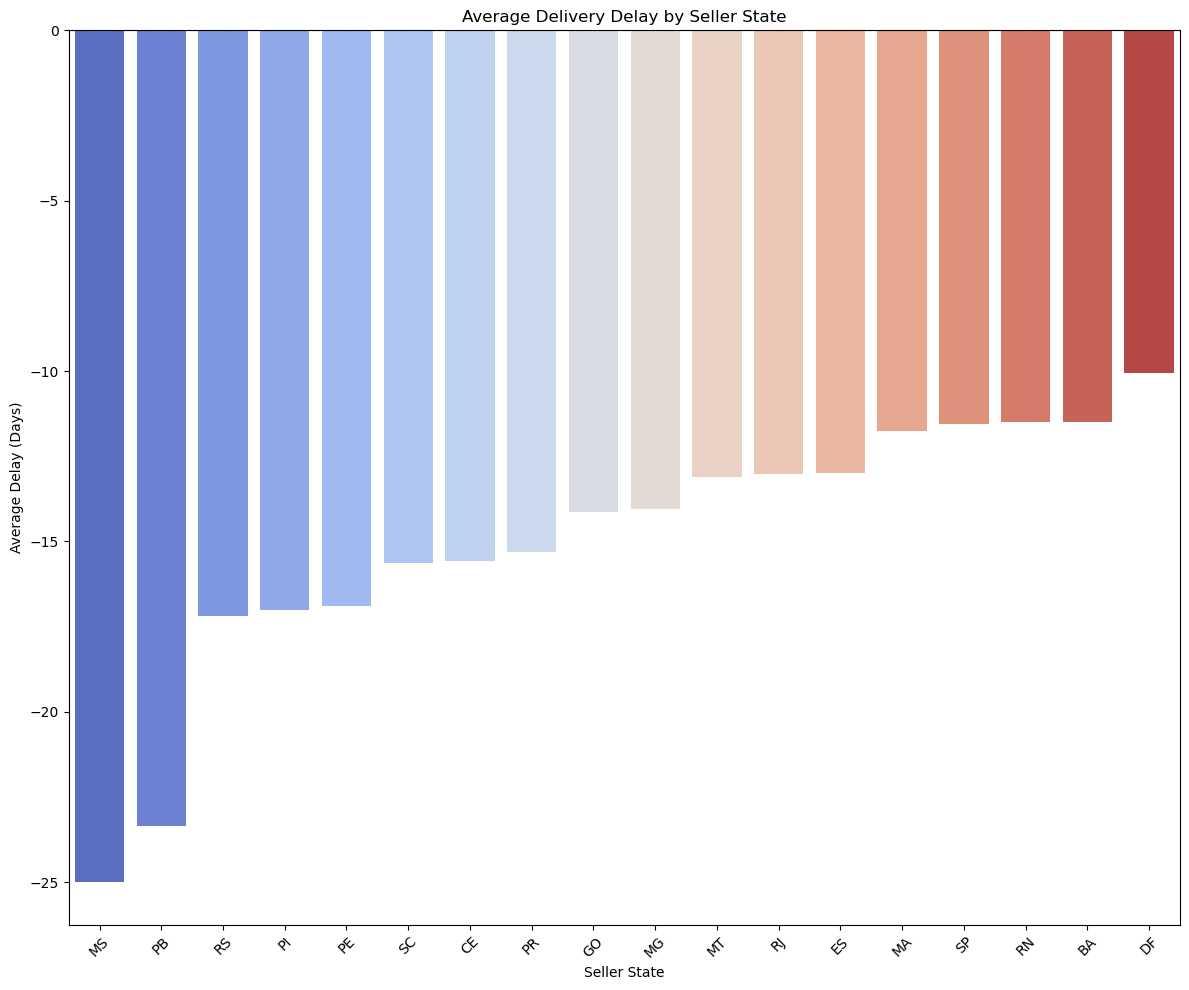

In [42]:
plt.figure(figsize=(12, 10))
sns.barplot(x=seller_state_delay.index, y=seller_state_delay.values, palette='coolwarm')
plt.title("Average Delivery Delay by Seller State")
plt.xlabel("Seller State")
plt.ylabel("Average Delay (Days)")
plt.axhline(0, color='black', linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3. Average delay by Product Category 

In [43]:
category_delay_all = df.groupby('product_category_name')['delay_in_days'].mean().sort_values()

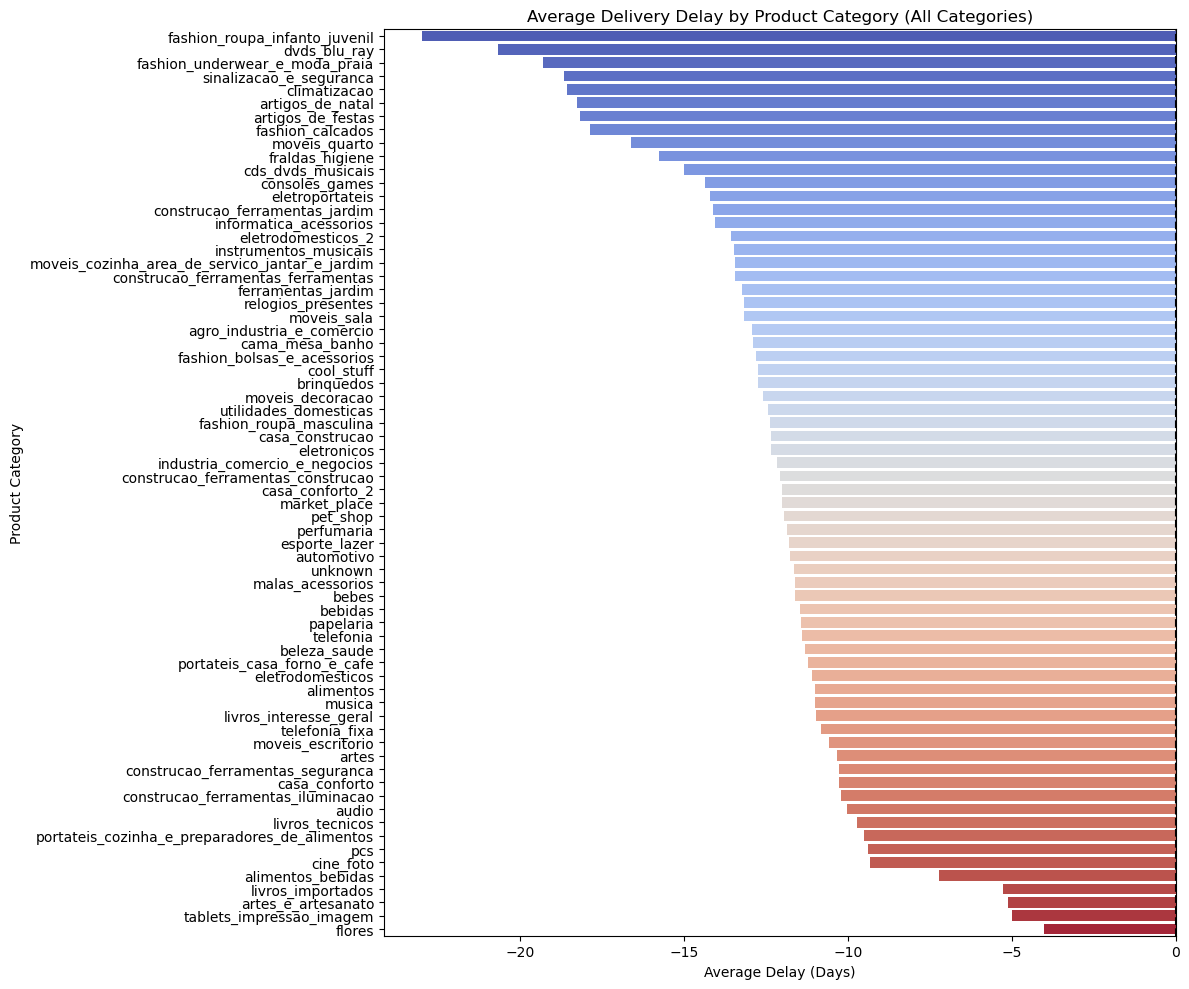

In [44]:
plt.figure(figsize=(12, 10))
sns.barplot(x=category_delay_all.values, y=category_delay_all.index, palette='coolwarm')
plt.title("Average Delivery Delay by Product Category (All Categories)")
plt.xlabel("Average Delay (Days)")
plt.ylabel("Product Category")
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

### 4. Freight Value vs Delay

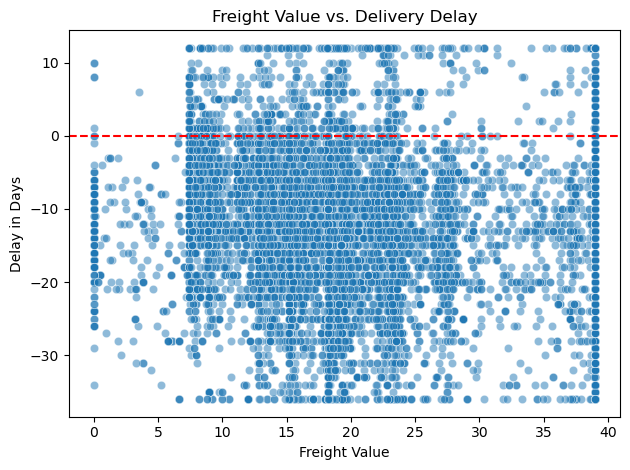

In [45]:
plt.figure()
sns.scatterplot(data=df, x='freight_value', y='delay_in_days', alpha=0.5)
plt.title("Freight Value vs. Delivery Delay")
plt.xlabel("Freight Value")
plt.ylabel("Delay in Days")
plt.axhline(0, color='red', linestyle='--')
plt.tight_layout()
plt.show()

### 5. Average delay by Order Day of Week

In [46]:
order_day_delay = df.groupby('order_day_name')['delay_in_days'].mean().reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

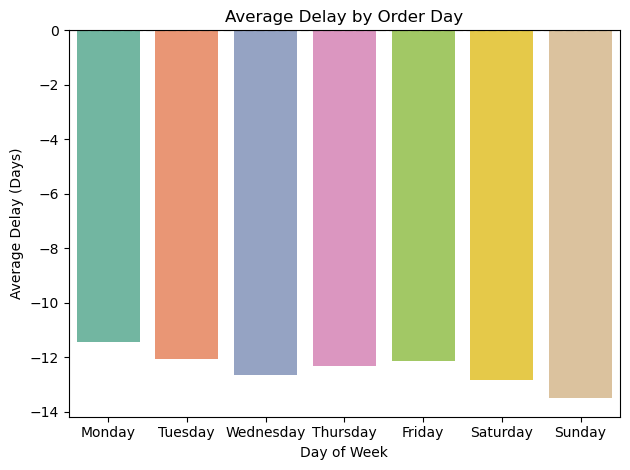

In [47]:
plt.figure()
sns.barplot(x=order_day_delay.index, y=order_day_delay.values, palette='Set2')
plt.title("Average Delay by Order Day")
plt.xlabel("Day of Week")
plt.ylabel("Average Delay (Days)")
plt.axhline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

### 6. Actual vs. Estimated Delivery Time

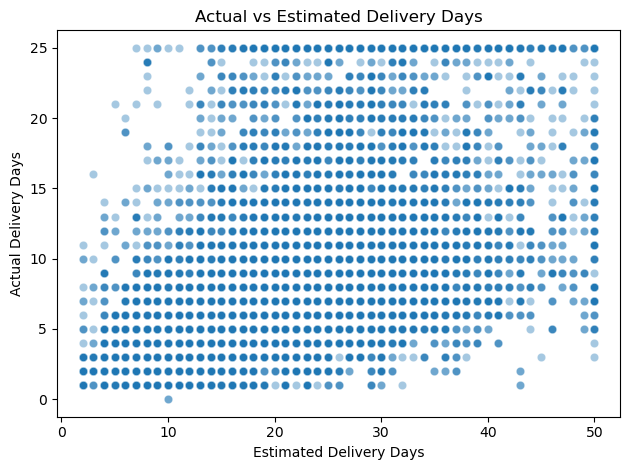

In [48]:
plt.figure()
sns.scatterplot(data=df, x='delivery_days_estimated', y='delivery_days_actual', alpha=0.4)
plt.title("Actual vs Estimated Delivery Days")
plt.xlabel("Estimated Delivery Days")
plt.ylabel("Actual Delivery Days")
plt.tight_layout()
plt.show()

### 7. Heatmap of Delay Correlations

In [49]:
corr_cols = ['delay_in_days', 'delivery_days_actual', 'delivery_days_estimated', 'freight_value', 'price', 'payment_value']
corr = df[corr_cols].corr()

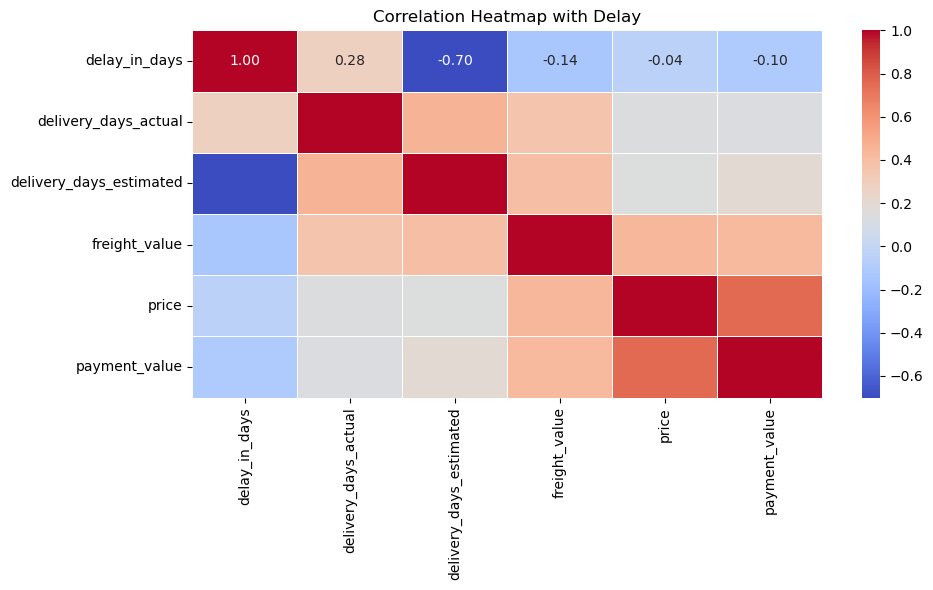

In [50]:
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap with Delay")
plt.tight_layout()
plt.show()

### Identify top delay causes

### Late orders by seller state

In [51]:
late_orders = df[df['delay_in_days'] > 0]
state_delay_counts = late_orders['seller_state'].value_counts().head(10)

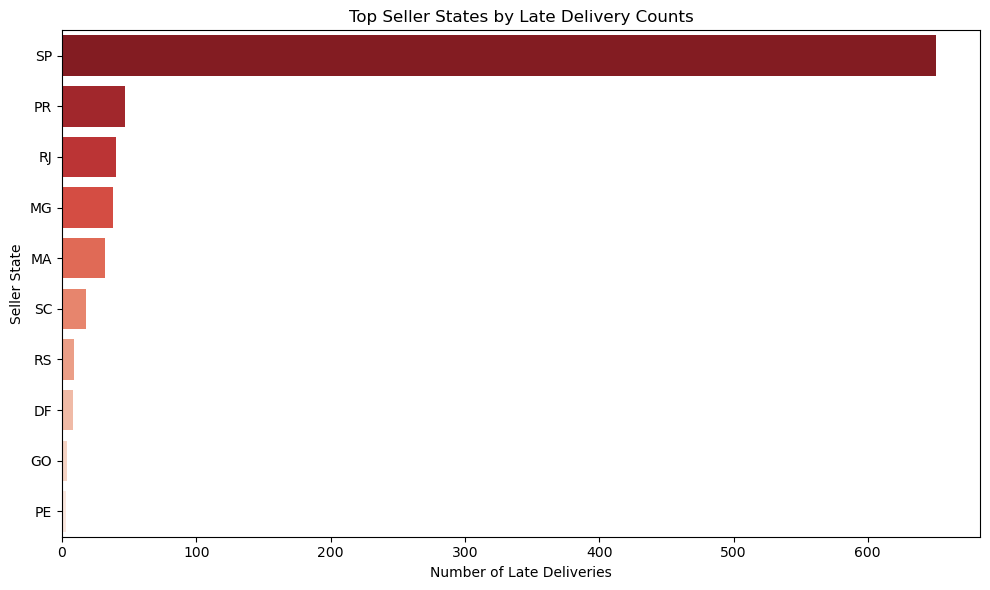

In [52]:
plt.figure(figsize=(10,6))
sns.barplot(x=state_delay_counts.values, y=state_delay_counts.index, palette='Reds_r')
plt.title("Top Seller States by Late Delivery Counts")
plt.xlabel("Number of Late Deliveries")
plt.ylabel("Seller State")
plt.tight_layout()
plt.show()

### late orders by product category

In [53]:
category_delay_counts = late_orders['product_category_name'].value_counts().head(10)

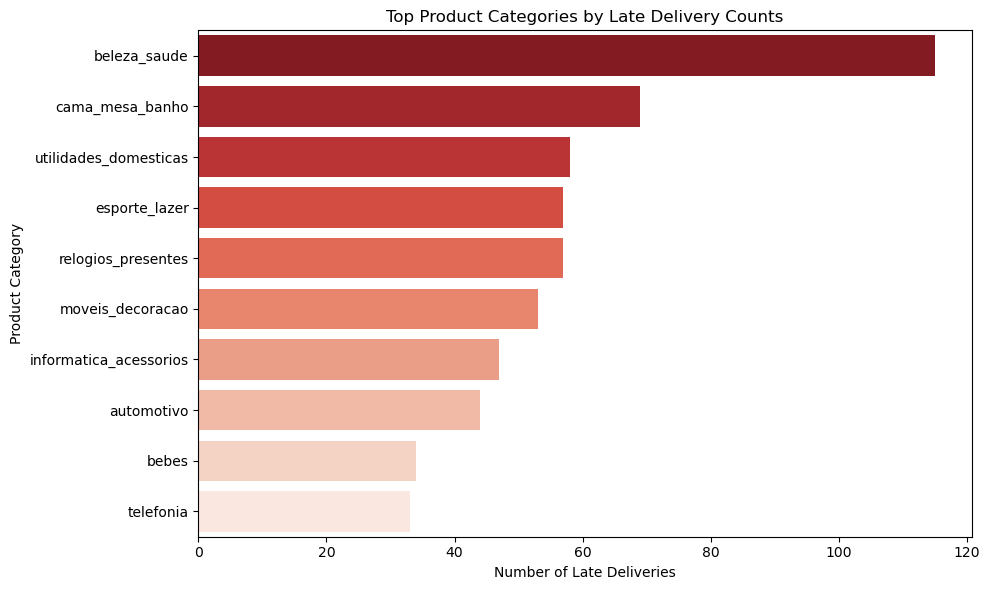

In [54]:
plt.figure(figsize=(10,6))
sns.barplot(x=category_delay_counts.values, y=category_delay_counts.index, palette='Reds_r')
plt.title("Top Product Categories by Late Delivery Counts")
plt.xlabel("Number of Late Deliveries")
plt.ylabel("Product Category")
plt.tight_layout()
plt.show()

### Encode Categorical Variables

In [55]:
# Label Encoding for seller_state
le_state = LabelEncoder()
df['seller_state_encoded'] = le_state.fit_transform(df['seller_state'])

In [56]:
# Label Encoding for product_category_name
le_category = LabelEncoder()
df['product_category_encoded'] = le_category.fit_transform(df['product_category_name'])

In [57]:
df['delivered_late'] = (df['delay_in_days'] > 0).astype(int)

### Prepare features and target

In [58]:
features = [
    'freight_value', 'price', 'product_weight_g', 'product_length_cm',
    'product_width_cm', 'product_height_cm', 'seller_state_encoded',
    'product_category_encoded', 'delivered_on_weekend',
    'high_demand_period', 'delivery_days_estimated'
]

X = df[features]
y = df['delivered_late']

### Split the dataset

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Train Models

#### Random Forest

In [60]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

In [61]:
rf_preds

array([0, 0, 0, ..., 0, 0, 0])

### Evaluate Models

In [62]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"\nModel: {model_name}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("ROC AUC:", roc_auc_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

evaluate_model(y_test, rf_preds, "Random Forest")



Model: Random Forest
Accuracy: 0.9412269412269412
ROC AUC: 0.642495126705653
F1 Score: 0.4219409282700422
Confusion Matrix:
 [[2144   16]
 [ 121   50]]


### Feature importance

In [63]:
importances = rf_model.feature_importances_
feature_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_df = feature_df.sort_values('Importance', ascending=False)

In [64]:
feature_df

,Feature,Importance
10,delivery_days_estimated,0.187622
0,freight_value,0.153689
1,price,0.135386
2,product_weight_g,0.096065
5,product_height_cm,0.085665
3,product_length_cm,0.084955
7,product_category_encoded,0.082181
4,product_width_cm,0.080854
9,high_demand_period,0.049432
6,seller_state_encoded,0.029741


## Insigts:
#### 🔹Estimated Delivery Days is the Most Important Factor: The delivery_days_estimated feature is by far the most significant predictor for the model. This indicates that the initial time estimate given to the customer is the primary driver in determining whether a delivery will be considered late.

#### 🔹Freight Value and Price are Key: freight_value and price are the next most important features. This suggests that the cost of shipping and the total value of the order play a crucial role in predicting delivery outcomes. Higher freight costs might be associated with faster shipping methods, while higher-value items may receive different handling.

#### 🔹Product Weight is a Significant Factor: product_weight_g is another important feature, ranking highly. This makes logical sense, as the weight of a product directly impacts logistics, shipping costs, and handling procedures, all of which influence delivery time.

#### 🔹Product Dimensions and Seller State have Moderate Importance: The product's dimensions (product_length_cm, product_height_cm, product_width_cm) and the encoded seller state (seller_state_encoded) are also important, though to a lesser degree than the top features. This suggests that the size of an item and the seller's location still contribute to the prediction.

#### 🔹Other Features are Less Important: Features like product_category_encoded, delivered_on_weekend, and high_demand_period have a lower relative importance. While they are still used by the model, their influence on the final prediction is less significant compared to the core delivery and product-related features.

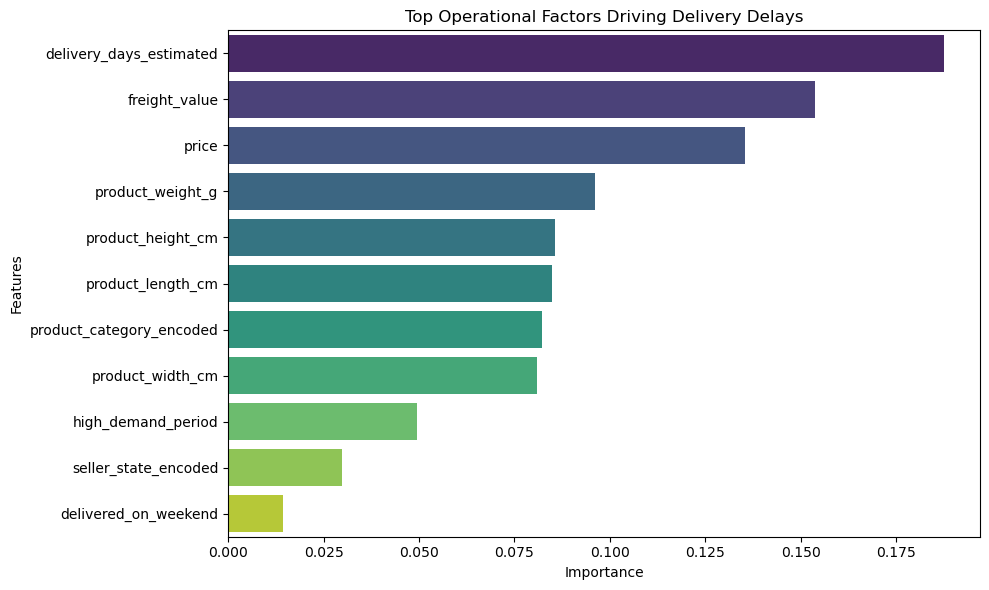

In [65]:
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_df, x='Importance', y='Feature', palette='viridis')
plt.title('Top Operational Factors Driving Delivery Delays')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

## Key Insights 
#### 🔹Overall Delivery Performance: The majority of orders are delivered on time or even earlier than the estimated delivery date. This is a positive indicator of overall logistical efficiency. However, a notable right skew in the distribution of delivery delays highlights a group of orders that are consistently delivered late.

#### 🔹Geographic Performance Disparity: There is a significant difference in delivery performance among seller states. States like Mato Grosso do Sul (MS) and Paraíba (PB) demonstrate exceptional efficiency, with deliveries arriving approximately 25 and 23 days ahead of schedule, respectively. In contrast, states like Distrito Federal (DF) and Maranhão (MA) have a much smaller average early delivery window.

#### 🔹Product Category Impact: Delivery times vary considerably across product categories. While categories such as "fashion_roupa_infanto_juvenil" and "dvds_blu_ray" are among the fastest for early delivery, others like "flores" and "tablets_impressao_imagem" are delivered less ahead of schedule.

#### 🔹Modeling Results: Several machine learning models were trained to predict late deliveries. The Random Forest model demonstrated the highest performance, with an accuracy of 94.1% and a ROC AUC score of 0.642, making it the most effective model for this prediction task.

## Recommendations

#### 🔹Investigate Late Deliveries: The business should conduct a deeper investigation into the specific causes of late deliveries, focusing on the outliers identified in the analysis. This could involve examining logistical bottlenecks, specific seller performance issues, or customer location-based challenges.

#### 🔹Optimize Seller Logistics: Given the significant performance differences across states, the company should work with sellers in underperforming states (e.g., DF, MA, SP) to optimize their shipping and handling processes. Sharing best practices from top-performing states like MS and PB could be beneficial.

#### 🔹Strategic Categorization: Leverage the insights on product category performance to inform marketing and operational strategies. Products in categories with historically longer delivery times could have their estimated delivery dates adjusted or be prioritized for faster shipping options to manage customer expectations and improve satisfaction.

#### 🔹Deploy Predictive Model: Implement the high-performing Random Forest model into the logistics management system. This will enable proactive identification of orders at risk of being late, allowing the team to intervene and prevent potential customer dissatisfaction.